In [5]:
import logging
from typing import Any, Dict, List, Optional, Sequence, Type, Union, Callable, Literal
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import Runnable
from langchain_ibm import WatsonxLLM as BaseWatsonxLLM
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.outputs import LLMResult, Generation, GenerationChunk
from langchain_core.messages import BaseMessage
from langchain_core.language_models import LanguageModelInput
from dotenv import load_dotenv
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from ibm_watsonx_ai.foundation_models.utils.enums import DecodingMethods
import os
import getpass

logger = logging.getLogger(__name__)

# Simplified loading of environment variables and IBM connection parameters
load_dotenv()

def set_env(var: str):
    env_var = os.getenv(var)
    if not env_var:
        env_var = getpass.getpass(f"{var}: ")
        os.environ[var] = env_var
    return env_var

class IbmConnectionParams(BaseModel):
    api_key: str
    project_id: str
    url: str
    credentials: dict[str, str]

    def __init__(self, api_key: str, project_id: str, url: str) -> None:
        super().__init__(api_key=api_key, project_id=project_id, url=url, credentials={"url": url, "apikey": api_key})

# Set IBM connection parameters
ibm_params = IbmConnectionParams(
    api_key=set_env("WATSONX_API_KEY"),
    project_id=set_env("PROJECT_ID"),
    url = set_env("WATSONX_URL")
)

parameters = {
    GenParams.DECODING_METHOD: DecodingMethods.SAMPLE.value,
    GenParams.MAX_NEW_TOKENS: 100,#1000,
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.TEMPERATURE: 0.7,
    GenParams.TOP_K: 50,
    GenParams.TOP_P: 1
}

class WatsonxLLM(BaseWatsonxLLM):
    """Extended IBM watsonx.ai large language models."""
    # Define the default parameters as class variables
    DEFAULT_MODEL_ID = "ibm/granite-13b-instruct-v2"
    DEFAULT_URL = ibm_params.url
    DEFAULT_APIKEY = ibm_params.api_key
    DEFAULT_PROJECT_ID = ibm_params.project_id
    DEFAULT_PARAMS = parameters    
    bound_tools: Optional[List[BaseTool]] = Field(default=None, exclude=True)

    def __init__(self, *args, tools: Optional[List[BaseTool]] = None, model_id: Optional[str] = None, **kwargs):
        if not model_id and 'deployment_id' not in kwargs:
            raise ValueError("One of 'model_id' or 'deployment_id' parameters should be set.")
        super().__init__(model_id=model_id, *args, **kwargs)
        self.bound_tools = tools or []

    def _generate(
        self,
        prompts: List[str],
        stop: Optional[List[str]] = None,
        run_manager: Optional[Any] = None,
        stream: Optional[bool] = None,
        **kwargs: Any,
    ) -> LLMResult:
        params = self._get_chat_params(stop=stop)
        should_stream = stream if stream is not None else self.streaming
        if should_stream:
            if len(prompts) > 1:
                raise ValueError(f"WatsonxLLM currently only supports single prompt, got {prompts}")
            generation = GenerationChunk(text="")
            stream_iter = self._stream(prompts[0], stop=stop, run_manager=run_manager, **kwargs)
            for chunk in stream_iter:
                if generation is None:
                    generation = chunk
                else:
                    generation += chunk
            assert generation is not None
            if isinstance(generation.generation_info, dict):
                llm_output = generation.generation_info.pop("llm_output")
                return LLMResult(generations=[[generation]], llm_output=llm_output)
            return LLMResult(generations=[[generation]])
        else:
            print("Step 1 - Starting Tool Evaluation")
                        
            if self.bound_tools:
                print("Step 1.1 self.bound_tools")
                print("type(self.bound_tools)", type(self.bound_tools)) 
                print("self.bound_tools", self.bound_tools)
                
                tool_output = self._evaluate_tools(self.bound_tools, prompts[0])
                logger.info("Tool output: %s", tool_output)

                system_prompt = (
                    f"You are an assistant with access to web search results. "
                    f"Provide a detailed answer to the user's query.\n\n"
                    f"User Query: {prompts[0]}\n\n"
                    f"Using the information below:\n"
                    f"Web Search Results: {tool_output}\n\n"
                )
                prompts[0] = system_prompt

            print("prompts", prompts)

            if not isinstance(params, dict):
                raise ValueError(f"Expected params to be a dictionary, got {type(params)}")

            response = self.watsonx_model.generate(prompt=prompts, params=params, **kwargs)
            return self._create_llm_result(response)


    def _evaluate_tools(self, tool_instances: List[BaseTool], input_text: str) -> str:
        combined_output = []
        print(f"Debug: Starting tool evaluation for input: {input_text}")
        print("tool_instances:", tool_instances)

        for tool in tool_instances:
            try:
                # Invoke the tool with the provided input
                result = tool.invoke(input_text)
                print(f"Debug: Result from tool {tool.name}: {result}")

                # Check the type of result and handle it accordingly
                if isinstance(result, str):
                    content = f"WebSearch Results: {result}"
                elif isinstance(result, list) and all(isinstance(item, dict) for item in result):
                    content = "WebSearch Results: " + " ".join(item.get('content', '') for item in result)
                elif isinstance(result, dict):
                    content = "WebSearch Results: " + result.get('content', 'Unknown response format')
                else:
                    content = "WebSearch Results: Invalid format received from tool"

                # Append the processed content to the combined output
                combined_output.append(content)

            except Exception as e:
                error_message = f"Error invoking tool {tool.name}: {str(e)}"
                print(f"Debug: {error_message}")
                combined_output.append(error_message)

        final_output = "\n\n".join(combined_output)
        print(f"Debug: Final combined output: {final_output}")
        return final_output

    @classmethod
    def bind_tools(
        cls,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        model_id: Optional[str] = None,
        url: Optional[str] = None,
        apikey: Optional[str] = None,
        project_id: Optional[str] = None,
        params: Optional[Dict[str, Any]] = None,
        tool_choice: Optional[Union[Dict[str, str], Literal["any", "auto"], str]] = None,
        **kwargs: Any,
    ) -> 'WatsonxLLM':
        formatted_tools = [convert_to_openai_tool(tool)["function"] for tool in tools]
        # Initialize WatsonxLLM with the provided parameters
        instance = cls(
            model_id=model_id,
            url=url,
            apikey=apikey,
            project_id=project_id,
            params=params,
            **kwargs
        )
        instance.bound_tools = tools
        if tool_choice is not None:
            kwargs["tool_choice"] = tool_choice
        return instance

    def _create_llm_result(self, response: List[dict]) -> LLMResult:
        generations = []
        for res in response:
            results = res.get("results")
            if results:
                finish_reason = results[0].get("stop_reason")
                gen = Generation(
                    text=results[0].get("generated_text"),
                    generation_info={"finish_reason": finish_reason},
                )
                generations.append([gen])
        final_token_usage = self._extract_token_usage(response)
        llm_output = {
            "token_usage": final_token_usage,
            "model_id": self.model_id,
            "deployment_id": self.deployment_id,
        }
        return LLMResult(generations=generations, llm_output=llm_output)

# Example usage:
tool = TavilySearchResults(max_results=4)

# Bind the tool and pass all necessary parameters inside `bind_tools`
llm_with_tools = WatsonxLLM.bind_tools(
    tools=[tool],
    model_id="ibm/granite-13b-instruct-v2",
    url=ibm_params.url,
    apikey=ibm_params.api_key,
    project_id=ibm_params.project_id,
    params=parameters
)
# Invoke the model
#response = llm_with_tools.invoke("Who is Ruslan Magana?")
#print(response)


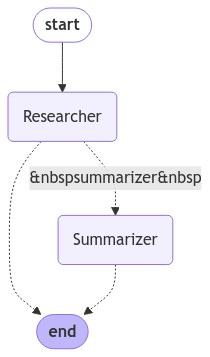

In [2]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message is research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "continue"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass




In [3]:
# Execute the graph stream with a test message
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="Fetch the bitcoin price over the past 5 days.")
        ]
    },
    {"recursion_limit": 50}
)

# Output the results
for s in events:
    print(s)
    print("----")

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices. Coins ... All Coins Compare Coins Converter Global Chart Exchanges Crypto Exchanges Decentralized Exchanges Derivatives NFT NFT ... 2024-09-05 $1,144,983,177,152 $37,550,380,697 $57,988 $56,132 Want data in another currency?'}, {'url': 'https://www.coindesk.com/price/bitcoin', 'content': 'The price of Bitcoin (BTC) is $62,513.88 today as of Oct 8, 2024, 7:24 am EDT, with a 24-hour trading volume of $30.79B. ... real-t

KeyError: 'summarizer'

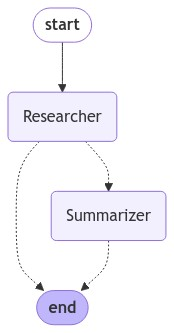

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.statmuse.com/money/ask?q=bitcoin+price+september+5th,+2024', 'content': 'Sep 08:00 56k 58k 54k 60k Zoom 1m 3m 6m YTD 1y All Sep 4, 2024 → Sep 5, 2024 BTC Price (Line) BTC Price (Candlestick) Daily pricing data for Bitcoin dates back to 7/17/2010, and may be incomplete. The closing price for Bitcoin (BTC) on September 5 was $56,144.18. It was down 3.1% for the day. The latest price is $65,558.01.'}, {'url': 'https://www.statmuse.com/money/ask/bitcoin-price-for-september-2024', 'content': 'The closing price for Bitcoin (BTC) this month is $59,112.48, yesterday

KeyError: 'Summarizer'

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message is research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "Summarizer"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


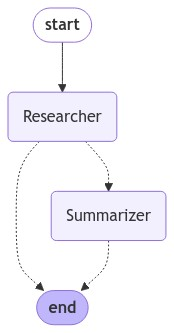

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices. Coins ... All Coins Compare Coins Converter Global Chart Exchanges Crypto Exchanges Decentralized Exchanges Derivatives NFT NFT ... 2024-09-05 $1,144,983,177,152 $37,550,380,697 $57,988 $56,132 Want data in another currency?'}, {'url': 'https://www.statmuse.com/money/ask/bitcoin-price-chart-2024-to-2024', 'content': 'Bitcoin Price Chart 2024 To 2024 | StatMuse Money Trending Trending Sports Trending Money Trending Liv

KeyError: 'Summarizer'

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
import re
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "Summarizer"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


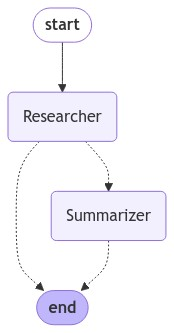

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://ycharts.com/indicators/bitcoin_price', 'content': 'In depth view into Bitcoin Price including historical data from 2014 to 2024, charts and stats. Bitcoin Price (I:BTCUSD) 62103.01 USD for Oct 05 2024 Overview ... Interactive Chart; More. Level Chart. Basic Info. Bitcoin Price is at a current level of 62103.01, up from 60727.86 yesterday and up from 27435.87 one year ago. ... September 09, 2024 ...'}, {'url': 'https://www.coindesk.com/price/bitcoin', 'content': 'The price of Bitcoin (BTC) is $62,513.88 today as of Oct 8, 2024, 7:24 am EDT, with a 24-hour trading

KeyError: 'Summarizer'

In [3]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "Summarizer"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")


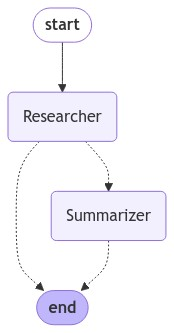

Step 1 - Starting Tool Evaluation
Step 1.1 self.bound_tools
type(self.bound_tools) <class 'list'>
self.bound_tools [TavilySearchResults()]
Debug: Starting tool evaluation for input: System: You are a helpful AI assistant. Use the provided tools to answer the question.
Human: Fetch the bitcoin price over the past 5 days.
tool_instances: [TavilySearchResults()]
Debug: Result from tool tavily_search_results_json: [{'url': 'https://www.coingecko.com/en/coins/bitcoin/historical_data', 'content': 'Get Bitcoin (BTC) USD historical prices. Get Bitcoin (BTC) USD historical prices. Coins ... All Coins Compare Coins Converter Global Chart Exchanges Crypto Exchanges Decentralized Exchanges Derivatives NFT NFT ... 2024-09-10 $1,126,840,069,632 $35,655,419,448 $57,049 $57,624 2024-09-09 $1,085,390,277,574'}, {'url': 'https://www.statmuse.com/money/ask/bitcoin-price-chart-2024-to-2024', 'content': 'Bitcoin Price Chart 2024 To 2024 | StatMuse Money Trending Trending Sports Trending Money Trending Live

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
import functools
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated, Sequence

# Define the object passed between nodes
class AgentState(TypedDict):
    messages: Sequence[AIMessage]
    sender: str

# Tool Initialization
tavily_tool = TavilySearchResults(max_results=5)  # Research tool to fetch Bitcoin prices
repl = PythonREPL()  # REPL for executing Python code (optional)

# Define the Researcher agent
def researcher_agent_node(state, agent, name):
    """Agent that researches Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Researcher Agent invoked with state: {state}")
    print(f"Debug: Research Result: {result}")

    return {
        "messages": [AIMessage(content=str(result), name=name)],
        "sender": name,
    }

# Define the Summarizer agent
def summarizer_agent_node(state, agent, name):
    """Agent that summarizes the fetched Bitcoin prices."""
    result = agent.invoke(state)
    print(f"Debug: Summarizer Agent invoked with state: {state}")
    print(f"Debug: Summary Result: {result}")

    return {
        "messages": [AIMessage(content="SUMMARY: " + str(result), name=name)],
        "sender": name,
    }

# Simplified agent creation function
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a helpful AI assistant. Use the provided tools to answer the question."),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(system_message=system_message)

    return prompt | llm.bind_tools(
        tools=tools,
        model_id="ibm/granite-13b-instruct-v2",
        url=ibm_params.url,
        apikey=ibm_params.api_key,
        project_id=ibm_params.project_id,
        params=parameters
    )

# Define agents
research_agent = create_agent(
    WatsonxLLM, [tavily_tool], system_message="Fetch Bitcoin prices over the last 5 days."
)
summarizer_agent = create_agent(
    WatsonxLLM, [], system_message="Summarize the fetched Bitcoin prices."
)

# Define nodes for each agent
research_node = functools.partial(researcher_agent_node, agent=research_agent, name="Researcher")
summarizer_node = functools.partial(summarizer_agent_node, agent=summarizer_agent, name="Summarizer")

# Router to determine the next step in the flow
def router(state) -> str:
    last_message = state["messages"][-1]
    print(f"Debug: Last message in state: {last_message}")
    
    # If the last message contains research data, proceed to summarize
    if "Bitcoin" in last_message.content or "Price" in last_message.content:
        print("Debug: Routing to Summarizer")
        return "Summarizer"

    # End the process after summarization
    if "SUMMARY" in last_message.content:
        print("Debug: Routing to __end__")
        return "__end__"

    return "Summarizer"

# Define the graph and its nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Summarizer", summarizer_node)
workflow.add_conditional_edges("Researcher", router, {"Summarizer": "Summarizer", "__end__": END})
workflow.add_conditional_edges("Summarizer", router, {"__end__": END})

# Set the entry point of the workflow
workflow.set_entry_point("Researcher")

# Compile the workflow for execution
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Function to evaluate a message and run the multi-agent system
def evaluate_message(message: str):
    """Function to evaluate the message using the multi-agent system."""
    events = graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        },
        {"recursion_limit": 50}
    )

    # Output the results
    for s in events:
        print(s)
        print("----")

# Example usage of the function:
evaluate_message("Fetch the bitcoin price over the past 5 days.")
